**In the Name of ALLAH who is the most Benificient and Mercifull**



In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
from tensorflow.keras import models, layers, regularizers

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/BraTS2021 Task 1.zip'

Archive:  /content/drive/MyDrive/BraTS2021 Task 1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  


In [ ]:
# import tarfile

# tar = tarfile.open("/content/BraTS2021_00495.tar", "r")
# tar.extractall()
# tar.close()

Custom Data Generator

In [ ]:
#from tifffile import imsave, imread
import os
import numpy as np

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [ ]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_images/"
train_mask_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

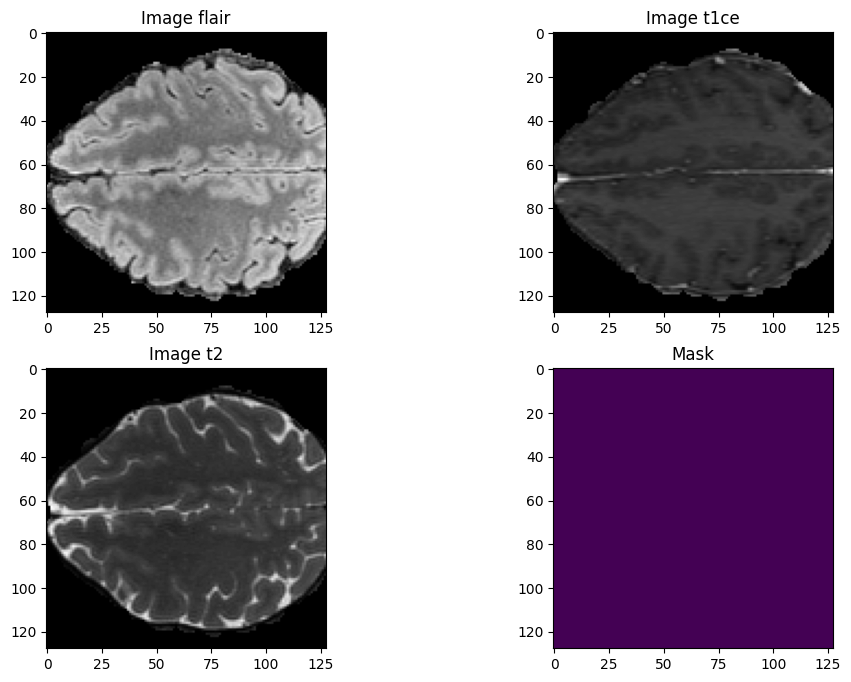

In [ ]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')

plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')

plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Loading Data from Image loader in the form of batches

In [ ]:
#Defining the image generators for training and validation


train_img_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_images/"
train_mask_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_masks/"


val_img_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/val/train_images/"
val_mask_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/val/train_masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

## Defining Loss Functions and Dice Coefficents

In [ ]:
def _dice_hard_coe(target, output, smooth=1e-5):
    output = tf.cast(output, dtype=tf.float32)
    target = tf.cast(target, dtype=tf.float32)

    inse = tf.reduce_sum(tf.multiply(output, target))
    l = tf.reduce_sum(output)
    r = tf.reduce_sum(target)
    hard_dice = (2. * inse + smooth) / (l + r + smooth)
    return tf.reduce_mean(hard_dice)

def brats_wt(y_true, y_pred):
    # whole tumor
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    gt_wt = tf.cast(tf.identity(y_true), tf.int32)
    gt_wt = tf.where(tf.equal(2, gt_wt), 1 * tf.ones_like(gt_wt), gt_wt)  # ground_truth_wt[ground_truth_wt == 2] = 1
    gt_wt = tf.where(tf.equal(3, gt_wt), 1 * tf.ones_like(gt_wt), gt_wt)  # ground_truth_wt[ground_truth_wt == 3] = 1
    pd_wt = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
    pd_wt = tf.where(tf.equal(2, pd_wt), 1 * tf.ones_like(pd_wt), pd_wt)  # predictions_wt[predictions_wt == 2] = 1
    pd_wt = tf.where(tf.equal(3, pd_wt), 1 * tf.ones_like(pd_wt), pd_wt)  # predictions_wt[predictions_wt == 3] = 1
    return _dice_hard_coe(gt_wt, pd_wt)


def brats_tc(y_true, y_pred):
    # tumor core
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    gt_tc = tf.cast(tf.identity(y_true), tf.int32)
    gt_tc = tf.where(tf.equal(2, gt_tc), 0 * tf.ones_like(gt_tc), gt_tc)  # ground_truth_tc[ground_truth_tc == 2] = 0
    gt_tc = tf.where(tf.equal(3, gt_tc), 1 * tf.ones_like(gt_tc), gt_tc)  # ground_truth_tc[ground_truth_tc == 3] = 1
    pd_tc = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
    pd_tc = tf.where(tf.equal(2, pd_tc), 0 * tf.ones_like(pd_tc), pd_tc)  # predictions_tc[predictions_tc == 2] = 0
    pd_tc = tf.where(tf.equal(3, pd_tc), 1 * tf.ones_like(pd_tc), pd_tc)  # predictions_tc[predictions_tc == 3] = 1
    return _dice_hard_coe(gt_tc, pd_tc)


def brats_et(y_true, y_pred):
    # enhancing tumor
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    gt_et = tf.cast(tf.identity(y_true), tf.int32)
    gt_et = tf.where(tf.equal(1, gt_et), 0 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 1] = 0
    gt_et = tf.where(tf.equal(2, gt_et), 0 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 2] = 0
    gt_et = tf.where(tf.equal(3, gt_et), 1 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 3] = 1
    pd_et = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
    pd_et = tf.where(tf.equal(1, pd_et), 0 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 1] = 0
    pd_et = tf.where(tf.equal(2, pd_et), 0 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 2] = 0
    pd_et = tf.where(tf.equal(3, pd_et), 1 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 3] = 1
    return _dice_hard_coe(gt_et, pd_et)

In [ ]:
def dice_coefficient(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

In [ ]:
# #Define loss, metrics and optimizer to be used for training
# wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

Sensitivity and Specifisity

In [ ]:
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# 3D Residual-UNet MOdel

In [ ]:
# Convolutional Blocks
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  return X

In [ ]:
# Residual Convolutional Blocks
def res_conv_block(x, filter_size, size, batch_norm=True):

    dropout = 0.1

    conv = layers.Conv3D(size, (filter_size, filter_size,filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=4)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv3D(size, (filter_size, filter_size,filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=4)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv3D(size, kernel_size=(1,1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=4)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

In [ ]:
# Model Design
def Residual_Unet_3d(input_img, n_filters = 16, dropout = 0.1, batch_norm = True):
## Downsaming - Encoder of U-Net with Residual Blocks
  c1 = res_conv_block(input_img,n_filters,3,batch_norm)
  p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = res_conv_block(p1,n_filters*2,3,batch_norm);
  p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
  p2 = Dropout(dropout)(p2)

  c3 = res_conv_block(p2,n_filters*4,3,batch_norm);
  p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = res_conv_block(p3,n_filters*8,3,batch_norm);
  p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
  p4 = Dropout(dropout)(p4)
## Bottleneck layer
  c5 = conv_block(p4,n_filters*16,3,batch_norm);
## UPsaming - Decoder of U-Net with Conv Blocks
  u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  c6 = Dropout(dropout)(c6)

  u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);
  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  c7 = Dropout(dropout)(c7)

  u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);
  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  c8 = Dropout(dropout)(c8)

  u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);
  u9 = concatenate([u9,c1]);
  c9 = conv_block(u9,n_filters,3,batch_norm)

  outputs = Conv3D(4,(1, 1,1), activation='softmax')(c9)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [ ]:
#Building model
input_img = Input((128,128,128,4))
res_unet = Residual_Unet_3d(input_img,16,0.1,True)
print(res_unet.input_shape)
print(res_unet.output_shape)

KeyboardInterrupt: ignored

**In the Name of ALLAH who is the most Benificient and Mercifull**



In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# import keras
# from matplotlib import pyplot as plt
# import glob
# import random
# from tensorflow.keras import models, layers, regularizers

# from keras.models import Model
# from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
# from tensorflow.keras.optimizers import Adam
# from keras.metrics import MeanIoU
# from tensorflow.keras.callbacks import ModelCheckpoint
# import tensorflow.keras.backend as K
# from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Custom Data Generator

In [ ]:
# #from tifffile import imsave, imread
# import os
# import numpy as np

# def load_img(img_dir, img_list):
#     images=[]
#     for i, image_name in enumerate(img_list):    
#         if (image_name.split('.')[1] == 'npy'):
            
#             image = np.load(img_dir+image_name)
                      
#             images.append(image)
#     images = np.array(images)
    
#     return(images)

In [ ]:
# def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

#     L = len(img_list)

#     #keras needs the generator infinite, so we will use while true  
#     while True:

#         batch_start = 0
#         batch_end = batch_size

#         while batch_start < L:
#             limit = min(batch_end, L)
                       
#             X = load_img(img_dir, img_list[batch_start:limit])
#             Y = load_img(mask_dir, mask_list[batch_start:limit])

#             yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

#             batch_start += batch_size   
#             batch_end += batch_size

In [ ]:
# #Test the generator

# from matplotlib import pyplot as plt
# import random

# train_img_dir = "/content/drive/MyDrive/BrainTumor/Dataset/Data_ImageGen128/Train_128_npy/train_images_128/"
# train_mask_dir = "/content/drive/MyDrive/BrainTumor/Dataset/Data_ImageGen128/Train_128_npy/train_masks_128/"

# # val_img_dir = "/content/drive/MyDrive/RR_Exp/Dataset/Data_Image_3Mod_128/Validation_npy/Valid_images_npy/"
# # val_mask_dir = "/content/drive/MyDrive/RR_Exp/Dataset/Data_Image_3Mod_128/Validation_npy/Valid_masks_npy/"

# train_img_list=os.listdir(train_img_dir)
# train_mask_list = os.listdir(train_mask_dir)

# batch_size = 1

# train_img_datagen = imageLoader(train_img_dir, train_img_list, 
#                                 train_mask_dir, train_mask_list, batch_size)

In [ ]:
# #Verify generator.... In python 3 next() is renamed as __next__()
# img, msk = train_img_datagen.__next__()

# img_num = random.randint(0,img.shape[0]-1)
# test_img=img[img_num]
# test_mask=msk[img_num]
# test_mask=np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')

# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')

# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')

# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()

Loading Data from Image loader in the form of batches

In [ ]:
# #Defining the image generators for training and validation

# train_img_dir = "/content/drive/MyDrive/BrainTumor/Dataset/Data_ImageGen128/Train_128_npy/train_images_128/"
# train_mask_dir = "/content/drive/MyDrive/BrainTumor/Dataset/Data_ImageGen128/Train_128_npy/train_masks_128/"

# val_img_dir = "/content/drive/MyDrive/BrainTumor/Dataset/Data_ImageGen128/Valid_128_npy/valid_images_128/"
# val_mask_dir = "/content/drive/MyDrive/BrainTumor/Dataset/Data_ImageGen128/Valid_128_npy/valid_masks_128/"

# train_img_list=os.listdir(train_img_dir)
# train_mask_list = os.listdir(train_mask_dir)

# val_img_list=os.listdir(val_img_dir)
# val_mask_list = os.listdir(val_mask_dir)

In [ ]:
# batch_size = 4

# train_img_datagen = imageLoader(train_img_dir, train_img_list, 
#                                 train_mask_dir, train_mask_list, batch_size)

# val_img_datagen = imageLoader(val_img_dir, val_img_list, 
#                                 val_mask_dir, val_mask_list, batch_size)

## Defining Loss Functions and Dice Coefficents

In [ ]:
# def _dice_hard_coe(target, output, smooth=1e-5):
#     output = tf.cast(output, dtype=tf.float32)
#     target = tf.cast(target, dtype=tf.float32)

#     inse = tf.reduce_sum(tf.multiply(output, target))
#     l = tf.reduce_sum(output)
#     r = tf.reduce_sum(target)
#     hard_dice = (2. * inse + smooth) / (l + r + smooth)
#     return tf.reduce_mean(hard_dice)

# def brats_wt(y_true, y_pred):
#     # whole tumor
#     y_true = tf.argmax(y_true, axis=-1)
#     y_pred = tf.argmax(y_pred, axis=-1)
#     gt_wt = tf.cast(tf.identity(y_true), tf.int32)
#     gt_wt = tf.where(tf.equal(2, gt_wt), 1 * tf.ones_like(gt_wt), gt_wt)  # ground_truth_wt[ground_truth_wt == 2] = 1
#     gt_wt = tf.where(tf.equal(3, gt_wt), 1 * tf.ones_like(gt_wt), gt_wt)  # ground_truth_wt[ground_truth_wt == 3] = 1
#     pd_wt = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
#     pd_wt = tf.where(tf.equal(2, pd_wt), 1 * tf.ones_like(pd_wt), pd_wt)  # predictions_wt[predictions_wt == 2] = 1
#     pd_wt = tf.where(tf.equal(3, pd_wt), 1 * tf.ones_like(pd_wt), pd_wt)  # predictions_wt[predictions_wt == 3] = 1
#     return _dice_hard_coe(gt_wt, pd_wt)


# def brats_tc(y_true, y_pred):
#     # tumor core
#     y_true = tf.argmax(y_true, axis=-1)
#     y_pred = tf.argmax(y_pred, axis=-1)
#     gt_tc = tf.cast(tf.identity(y_true), tf.int32)
#     gt_tc = tf.where(tf.equal(2, gt_tc), 0 * tf.ones_like(gt_tc), gt_tc)  # ground_truth_tc[ground_truth_tc == 2] = 0
#     gt_tc = tf.where(tf.equal(3, gt_tc), 1 * tf.ones_like(gt_tc), gt_tc)  # ground_truth_tc[ground_truth_tc == 3] = 1
#     pd_tc = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
#     pd_tc = tf.where(tf.equal(2, pd_tc), 0 * tf.ones_like(pd_tc), pd_tc)  # predictions_tc[predictions_tc == 2] = 0
#     pd_tc = tf.where(tf.equal(3, pd_tc), 1 * tf.ones_like(pd_tc), pd_tc)  # predictions_tc[predictions_tc == 3] = 1
#     return _dice_hard_coe(gt_tc, pd_tc)


# def brats_et(y_true, y_pred):
#     # enhancing tumor
#     y_true = tf.argmax(y_true, axis=-1)
#     y_pred = tf.argmax(y_pred, axis=-1)
#     gt_et = tf.cast(tf.identity(y_true), tf.int32)
#     gt_et = tf.where(tf.equal(1, gt_et), 0 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 1] = 0
#     gt_et = tf.where(tf.equal(2, gt_et), 0 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 2] = 0
#     gt_et = tf.where(tf.equal(3, gt_et), 1 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 3] = 1
#     pd_et = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
#     pd_et = tf.where(tf.equal(1, pd_et), 0 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 1] = 0
#     pd_et = tf.where(tf.equal(2, pd_et), 0 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 2] = 0
#     pd_et = tf.where(tf.equal(3, pd_et), 1 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 3] = 1
#     return _dice_hard_coe(gt_et, pd_et)

In [ ]:
# def dice_coefficient(y_true, y_pred, epsilon=0.00001):
#     """
#     Dice = (2*|X & Y|)/ (|X|+ |Y|)
#          =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
#     ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
#     """
#     axis = (0,1,2,3)
#     dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
#     dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
#     return K.mean((dice_numerator)/(dice_denominator))

In [ ]:
# def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
#                    epsilon=0.00001):
#     """
#     Compute mean soft dice loss over all abnormality classes.

#     Args:
#         y_true (Tensorflow tensor): tensor of ground truth values for all classes.
#                                     shape: (num_classes, x_dim, y_dim, z_dim)
#         y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
#                                     shape: (num_classes, x_dim, y_dim, z_dim)
#         axis (tuple): spatial axes to sum over when computing numerator and
#                       denominator in formula for dice loss.
#                       Hint: pass this as the 'axis' argument to the K.sum
#                             and K.mean functions.
#         epsilon (float): small constant added to numerator and denominator to
#                         avoid divide by 0 errors.
#     Returns:
#         dice_loss (float): computed value of dice loss.     
#     """

#     dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
#     dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
#     dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

#     return dice_loss

Sensitivity and Specifisity

In [ ]:
# # Computing Sensitivity      
# def sensitivity(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + K.epsilon())


# # Computing Specificity
# def specificity(y_true, y_pred):
#     true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
#     possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
#     return true_negatives / (possible_negatives + K.epsilon())

Model Compiling:

In [ ]:
metrics = [dice_coefficient, brats_wt , brats_tc ,brats_et,sensitivity,specificity]
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
res_unet.compile(optimizer = optimizer, loss=soft_dice_loss, metrics=metrics)
res_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  49155       ['input_1[0][0]']                
                                8, 3)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  12         ['conv3d[0][0]']                 
 alization)                     8, 3)                                                         

In [ ]:
#Fit the model 
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

Model Training: Fitting the model over train and validation data

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Checkpoints' 
callbacks = []
callbacks.append(ModelCheckpoint(checkpoint_path + '/FResUnet_epoch-{epoch}.h5'))

# Model Training 

In [ ]:
history=res_unet.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )

Epoch 1/10
230/230 [==============================] - 2996s 11s/step - loss: 0.6143 - dice_coefficient: 0.4065 - brats_wt: 0.2684 - brats_tc: 0.0762 - brats_et: 0.4531 - sensitivity: 0.5075 - specificity: 0.9878 - val_loss: 0.7318 - val_dice_coefficient: 0.2703 - val_brats_wt: 0.2561 - val_brats_tc: 0.0847 - val_brats_et: 0.0953 - val_sensitivity: 0.3213 - val_specificity: 0.9330
Epoch 2/10
230/230 [==============================] - 2429s 11s/step - loss: 0.4300 - dice_coefficient: 0.6028 - brats_wt: 0.7390 - brats_tc: 0.5044 - brats_et: 0.6443 - sensitivity: 0.9200 - specificity: 0.9914 - val_loss: 0.4753 - val_dice_coefficient: 0.5503 - val_brats_wt: 0.6543 - val_brats_tc: 0.4783 - val_brats_et: 0.4220 - val_sensitivity: 0.9384 - val_specificity: 0.9839
Epoch 3/10
230/230 [==============================] - 2401s 10s/step - loss: 0.3185 - dice_coefficient: 0.7254 - brats_wt: 0.7940 - brats_tc: 0.6833 - brats_et: 0.6722 - sensitivity: 0.9694 - specificity: 0.9917 - val_loss: 0.4316 - v

In [ ]:
# Model Loading 
model1 = keras.models.load_model("/content/drive/MyDrive/Checkpoints/FResUnet_epoch-45.h5",
                                 custom_objects={'soft_dice_loss': soft_dice_loss,
                                 'dice_coefficient':dice_coefficient,'brats_wt':brats_wt,
                                 'brats_tc' : brats_tc , 'brats_et':brats_et,'sensitivity':sensitivity,'specificity':specificity
                                 },)

In [ ]:
metrics = [dice_coefficient, brats_wt , brats_tc ,brats_et,sensitivity,specificity]
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
model1.compile(optimizer = optimizer, loss=soft_dice_loss, metrics=metrics)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  49155       ['input_1[0][0]']                
                                8, 3)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  12         ['conv3d[0][0]']                 
 alization)                     8, 3)                                                         

In [ ]:
# model1.fit(train_data, train_labels, validation_data=(val_data, val_labels), batch_size=32, epochs=10, initial_epoch=5, callbacks=[checkpoint_callback])

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Checkpoints' 
callbacks = []
callbacks.append(ModelCheckpoint(checkpoint_path + '/FResUnet_epoch-{epoch}.h5'))

In [ ]:
history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,initial_epoch=45,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)

Epoch 46/50
230/230 [==============================] - 4466s 18s/step - loss: 0.1306 - dice_coefficient: 0.9001 - brats_wt: 0.9078 - brats_tc: 0.9122 - brats_et: 0.8582 - sensitivity: 0.9880 - specificity: 0.9963 - val_loss: 0.2232 - val_dice_coefficient: 0.8273 - val_brats_wt: 0.8341 - val_brats_tc: 0.7941 - val_brats_et: 0.7873 - val_sensitivity: 0.9785 - val_specificity: 0.9931
Epoch 47/50
230/230 [==============================] - 4193s 18s/step - loss: 0.1305 - dice_coefficient: 0.8997 - brats_wt: 0.9075 - brats_tc: 0.9108 - brats_et: 0.8583 - sensitivity: 0.9880 - specificity: 0.9963 - val_loss: 0.2204 - val_dice_coefficient: 0.8269 - val_brats_wt: 0.8206 - val_brats_tc: 0.8121 - val_brats_et: 0.8001 - val_sensitivity: 0.9766 - val_specificity: 0.9925
Epoch 48/50
230/230 [==============================] - 4198s 18s/step - loss: 0.1297 - dice_coefficient: 0.9006 - brats_wt: 0.9065 - brats_tc: 0.9111 - brats_et: 0.8606 - sensitivity: 0.9879 - specificity: 0.9963 - val_loss: 0.2283 

Epoch 41/45
230/230 [==============================] - 4464s 18s/step - loss: 0.1362 - dice_coefficient: 0.8952 - brats_wt: 0.9024 - brats_tc: 0.9062 - brats_et: 0.8541 - sensitivity: 0.9874 - specificity: 0.9961 - val_loss: 0.2263 - val_dice_coefficient: 0.8235 - val_brats_wt: 0.8182 - val_brats_tc: 0.8021 - val_brats_et: 0.7811 - val_sensitivity: 0.9759 - val_specificity: 0.9923
Epoch 42/45
230/230 [==============================] - 4194s 18s/step - loss: 0.1357 - dice_coefficient: 0.8957 - brats_wt: 0.9031 - brats_tc: 0.9060 - brats_et: 0.8537 - sensitivity: 0.9875 - specificity: 0.9962 - val_loss: 0.2158 - val_dice_coefficient: 0.8312 - val_brats_wt: 0.8467 - val_brats_tc: 0.7992 - val_brats_et: 0.8017 - val_sensitivity: 0.9803 - val_specificity: 0.9937
Epoch 43/45
230/230 [==============================] - 4201s 18s/step - loss: 0.1367 - dice_coefficient: 0.8944 - brats_wt: 0.9024 - brats_tc: 0.9053 - brats_et: 0.8518 - sensitivity: 0.9873 - specificity: 0.9961 - val_loss: 0.2245 

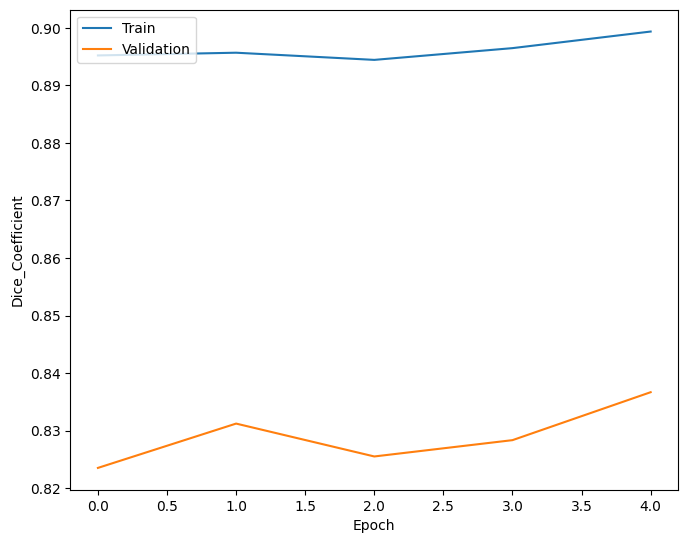

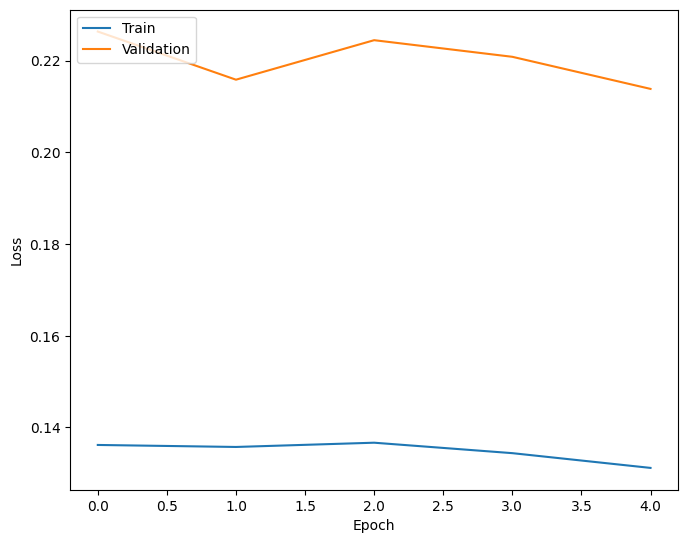

In [ ]:

history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=45,initial_epoch=40,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)

# Retaining after 17th Epoch

Epoch 18/25
230/230 [==============================] - 3405s 13s/step - loss: 0.1779 - dice_coefficient: 0.8567 - brats_wt: 0.8746 - brats_tc: 0.8581 - brats_et: 0.8077 - sensitivity: 0.9834 - specificity: 0.9950 - val_loss: 0.2729 - val_dice_coefficient: 0.7657 - val_brats_wt: 0.7945 - val_brats_tc: 0.7117 - val_brats_et: 0.6555 - val_sensitivity: 0.9705 - val_specificity: 0.9913
Epoch 19/25
230/230 [==============================] - 2888s 13s/step - loss: 0.1743 - dice_coefficient: 0.8590 - brats_wt: 0.8782 - brats_tc: 0.8615 - brats_et: 0.8132 - sensitivity: 0.9838 - specificity: 0.9951 - val_loss: 0.2456 - val_dice_coefficient: 0.8016 - val_brats_wt: 0.8175 - val_brats_tc: 0.7755 - val_brats_et: 0.7516 - val_sensitivity: 0.9766 - val_specificity: 0.9927
Epoch 20/25
230/230 [==============================] - 2887s 13s/step - loss: 0.1712 - dice_coefficient: 0.8626 - brats_wt: 0.8808 - brats_tc: 0.8656 - brats_et: 0.8169 - sensitivity: 0.9842 - specificity: 0.9952 - val_loss: 0.2359 

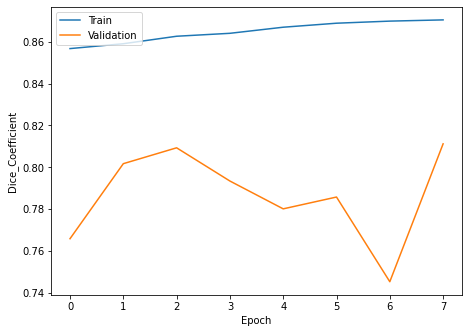

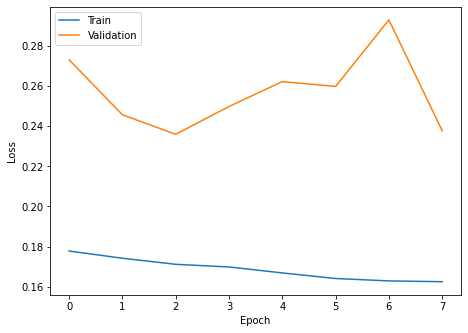

In [ ]:

history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,initial_epoch=17,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)

In [ ]:
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()


# Dice_coefficient_Graph 10th epoch

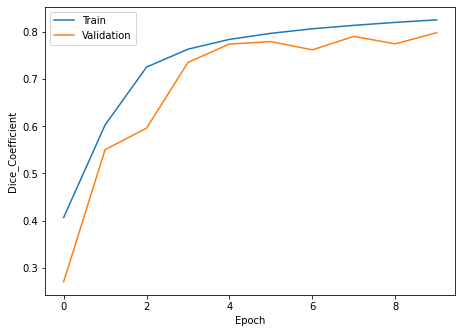

In [ ]:
Dice_coefficient_Graph(history)

# Loss Graph


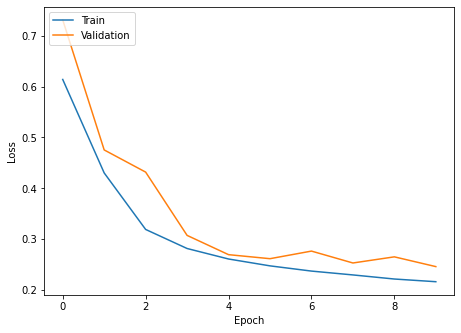

In [ ]:
Loss_Graph(history)

# Retraining After 25th epoch 

Epoch 26/30
230/230 [==============================] - 3445s 13s/step - loss: 0.1575 - dice_coefficient: 0.8754 - brats_wt: 0.8882 - brats_tc: 0.8826 - brats_et: 0.8302 - sensitivity: 0.9854 - specificity: 0.9956 - val_loss: 0.2323 - val_dice_coefficient: 0.8132 - val_brats_wt: 0.8251 - val_brats_tc: 0.7871 - val_brats_et: 0.7658 - val_sensitivity: 0.9773 - val_specificity: 0.9928
Epoch 27/30
230/230 [==============================] - 2977s 13s/step - loss: 0.1555 - dice_coefficient: 0.8774 - brats_wt: 0.8896 - brats_tc: 0.8854 - brats_et: 0.8331 - sensitivity: 0.9856 - specificity: 0.9956 - val_loss: 0.2527 - val_dice_coefficient: 0.7916 - val_brats_wt: 0.8042 - val_brats_tc: 0.7607 - val_brats_et: 0.7213 - val_sensitivity: 0.9734 - val_specificity: 0.9918
Epoch 28/30
230/230 [==============================] - 2947s 13s/step - loss: 0.1562 - dice_coefficient: 0.8767 - brats_wt: 0.8898 - brats_tc: 0.8828 - brats_et: 0.8303 - sensitivity: 0.9855 - specificity: 0.9956 - val_loss: 0.2346 

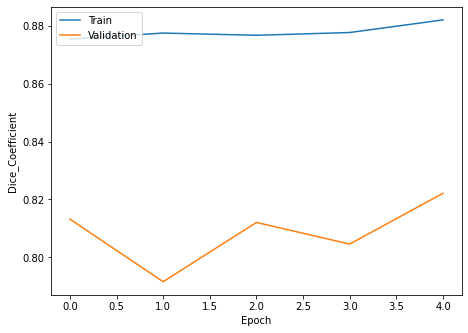

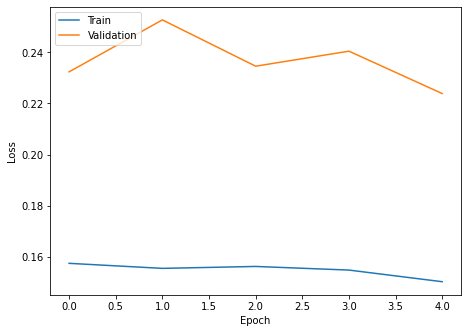

In [ ]:
history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,initial_epoch=25,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)

# After 30th Epoch

Epoch 31/35
230/230 [==============================] - 2983s 13s/step - loss: 0.1499 - dice_coefficient: 0.8825 - brats_wt: 0.8932 - brats_tc: 0.8910 - brats_et: 0.8391 - sensitivity: 0.9861 - specificity: 0.9958 - val_loss: 0.2365 - val_dice_coefficient: 0.8075 - val_brats_wt: 0.8161 - val_brats_tc: 0.7769 - val_brats_et: 0.7473 - val_sensitivity: 0.9756 - val_specificity: 0.9924
Epoch 32/35
230/230 [==============================] - 2994s 13s/step - loss: 0.1465 - dice_coefficient: 0.8851 - brats_wt: 0.8968 - brats_tc: 0.8937 - brats_et: 0.8418 - sensitivity: 0.9864 - specificity: 0.9959 - val_loss: 0.2598 - val_dice_coefficient: 0.7833 - val_brats_wt: 0.7740 - val_brats_tc: 0.7567 - val_brats_et: 0.7060 - val_sensitivity: 0.9674 - val_specificity: 0.9899
Epoch 33/35
230/230 [==============================] - 2987s 13s/step - loss: 0.1479 - dice_coefficient: 0.8845 - brats_wt: 0.8947 - brats_tc: 0.8935 - brats_et: 0.8389 - sensitivity: 0.9864 - specificity: 0.9958 - val_loss: 0.2287 

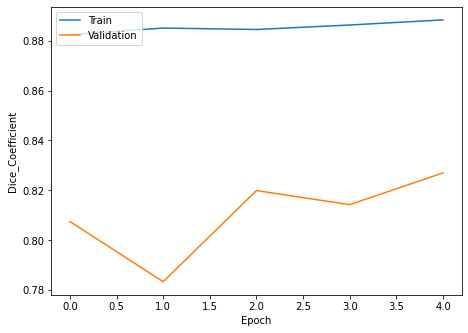

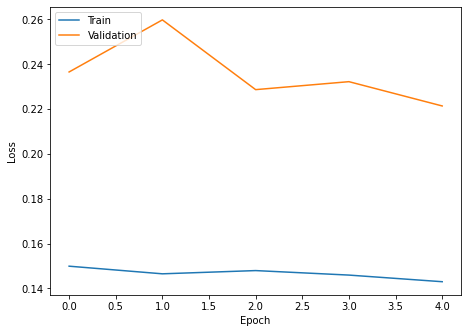

In [ ]:
history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=35,initial_epoch=30,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)

# After 35th Epochs 

Epoch 36/40
230/230 [==============================] - 3401s 13s/step - loss: 0.1425 - dice_coefficient: 0.8898 - brats_wt: 0.8993 - brats_tc: 0.9008 - brats_et: 0.8463 - sensitivity: 0.9869 - specificity: 0.9960 - val_loss: 0.2344 - val_dice_coefficient: 0.8144 - val_brats_wt: 0.8029 - val_brats_tc: 0.7963 - val_brats_et: 0.7797 - val_sensitivity: 0.9737 - val_specificity: 0.9916
Epoch 37/40
230/230 [==============================] - 2893s 13s/step - loss: 0.1424 - dice_coefficient: 0.8893 - brats_wt: 0.8983 - brats_tc: 0.8989 - brats_et: 0.8462 - sensitivity: 0.9868 - specificity: 0.9960 - val_loss: 0.2262 - val_dice_coefficient: 0.8237 - val_brats_wt: 0.8406 - val_brats_tc: 0.7927 - val_brats_et: 0.7938 - val_sensitivity: 0.9806 - val_specificity: 0.9938
Epoch 38/40
230/230 [==============================] - 2888s 13s/step - loss: 0.1408 - dice_coefficient: 0.8910 - brats_wt: 0.8991 - brats_tc: 0.9009 - brats_et: 0.8492 - sensitivity: 0.9870 - specificity: 0.9960 - val_loss: 0.2230 

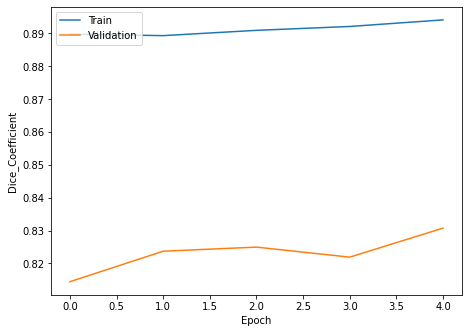

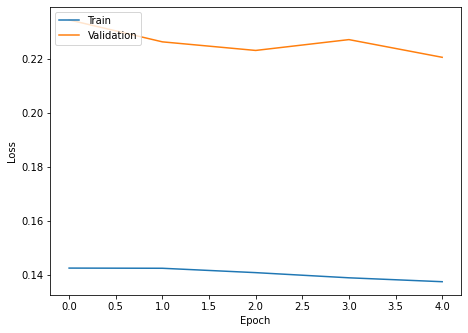

In [ ]:
history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,initial_epoch=35,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):
    

    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

Dice_coefficient_Graph(history)
Loss_Graph(history)

#After 40th epoch


In [ ]:

history=model1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,initial_epoch=45,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[callbacks], verbose=1
          )
# Dice Similarity Coefficient vs Epoch
# def Dice_coefficient_Graph(history):
    

#     plt.plot(history.history['dice_coefficient'])
#     plt.plot(history.history['val_dice_coefficient'])
#     #plt.title('Dice_Coefficient')
#     plt.ylabel('Dice_Coefficient')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')
#     plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
#                         wspace=0.35)
#     plt.show()
# # Loss vs Epoch
# def Loss_Graph(history):

#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     #plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')
#     plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
#                         wspace=0.35)
#     plt.show()

# Dice_coefficient_Graph(history)
# Loss_Graph(history)

# Model Prediction 

In [ ]:
model1 = keras.models.load_model("/content/drive/MyDrive/Checkpoints/FResUnet_epoch-40.h5",
                                 custom_objects={'soft_dice_loss': soft_dice_loss,
                                 'dice_coefficient':dice_coefficient,'brats_wt':brats_wt,
                                 'brats_tc' : brats_tc , 'brats_et':brats_et,'sensitivity':sensitivity,'specificity':specificity
                                 },)

In [ ]:

# #Verify generator.... In python 3 next() is renamed as __next__()
# test_image_batch, test_mask_batch = test_img_datagen.__next__()

# # Evaluating the model on the Test Data
# model1.evaluate(x=test_image_batch, y=test_mask_batch, batch_size=10, verbose=1, sample_weight=None, steps=None)

In [ ]:
!pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install Keras-Applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
import segmentation_models_3D as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
def _dice_hard_coe(target, output, smooth=1e-5):
    output = tf.cast(output, dtype=tf.float32)
    target = tf.cast(target, dtype=tf.float32)

    inse = tf.reduce_sum(tf.multiply(output, target))
    l = tf.reduce_sum(output)
    r = tf.reduce_sum(target)
    hard_dice = (2. * inse + smooth) / (l + r + smooth)
    return tf.reduce_mean(hard_dice)

def brats_wt(y_true, y_pred):
    # whole tumor
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    gt_wt = tf.cast(tf.identity(y_true), tf.int32)
    gt_wt = tf.where(tf.equal(2, gt_wt), 1 * tf.ones_like(gt_wt), gt_wt)  # ground_truth_wt[ground_truth_wt == 2] = 1
    gt_wt = tf.where(tf.equal(3, gt_wt), 1 * tf.ones_like(gt_wt), gt_wt)  # ground_truth_wt[ground_truth_wt == 3] = 1
    pd_wt = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
    pd_wt = tf.where(tf.equal(2, pd_wt), 1 * tf.ones_like(pd_wt), pd_wt)  # predictions_wt[predictions_wt == 2] = 1
    pd_wt = tf.where(tf.equal(3, pd_wt), 1 * tf.ones_like(pd_wt), pd_wt)  # predictions_wt[predictions_wt == 3] = 1
    return _dice_hard_coe(gt_wt, pd_wt)


def brats_tc(y_true, y_pred):
    # tumor core
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    gt_tc = tf.cast(tf.identity(y_true), tf.int32)
    gt_tc = tf.where(tf.equal(2, gt_tc), 0 * tf.ones_like(gt_tc), gt_tc)  # ground_truth_tc[ground_truth_tc == 2] = 0
    gt_tc = tf.where(tf.equal(3, gt_tc), 1 * tf.ones_like(gt_tc), gt_tc)  # ground_truth_tc[ground_truth_tc == 3] = 1
    pd_tc = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
    pd_tc = tf.where(tf.equal(2, pd_tc), 0 * tf.ones_like(pd_tc), pd_tc)  # predictions_tc[predictions_tc == 2] = 0
    pd_tc = tf.where(tf.equal(3, pd_tc), 1 * tf.ones_like(pd_tc), pd_tc)  # predictions_tc[predictions_tc == 3] = 1
    return _dice_hard_coe(gt_tc, pd_tc)


def brats_et(y_true, y_pred):
    # enhancing tumor
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    gt_et = tf.cast(tf.identity(y_true), tf.int32)
    gt_et = tf.where(tf.equal(1, gt_et), 0 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 1] = 0
    gt_et = tf.where(tf.equal(2, gt_et), 0 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 2] = 0
    gt_et = tf.where(tf.equal(3, gt_et), 1 * tf.ones_like(gt_et), gt_et)  # ground_truth_et[ground_truth_et == 3] = 1
    pd_et = tf.cast(tf.round(tf.identity(y_pred)), tf.int32)
    pd_et = tf.where(tf.equal(1, pd_et), 0 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 1] = 0
    pd_et = tf.where(tf.equal(2, pd_et), 0 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 2] = 0
    pd_et = tf.where(tf.equal(3, pd_et), 1 * tf.ones_like(pd_et), pd_et)  # predictions_et[predictions_et == 3] = 1
    return _dice_hard_coe(gt_et, pd_et)

In [ ]:
def dice_coefficient(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

In [ ]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
def weighted_dice_coefficient_per_class(y_true, y_pred, class_to_predict=0, smooth=0.00001):
    axis = tuple(range(y_pred.shape.rank - 1))

    return (2. * (K.sum(y_true * y_pred,
                              axis=axis) + smooth / 2) / (K.sum(y_true,
                                                                axis=axis) + K.sum(y_pred,
                                                                                   axis=axis) + smooth))[class_to_predict]


def weighted_dice_coefficient(y_true, y_pred, smooth=0.00001):
    axis = tuple(range(y_pred.shape.rank - 1))

    return K.mean(2. * (K.sum(y_true * y_pred,
                              axis=axis) + smooth / 2) / (K.sum(y_true,
                                                                axis=axis) + K.sum(y_pred,
                                                                                   axis=axis) + smooth))


def weighted_dice_coefficient_loss(y_true, y_pred):
    return -weighted_dice_coefficient(y_true, y_pred)

In [ ]:
from matplotlib import pyplot as plt
import random

test_img_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/val/train_images/"
test_mask_dir = "/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/val/train_masks/"

test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

batch_size = 1

test_img_datagen = imageLoader(test_img_dir, test_img_list, 
                                test_mask_dir, test_mask_list, batch_size)

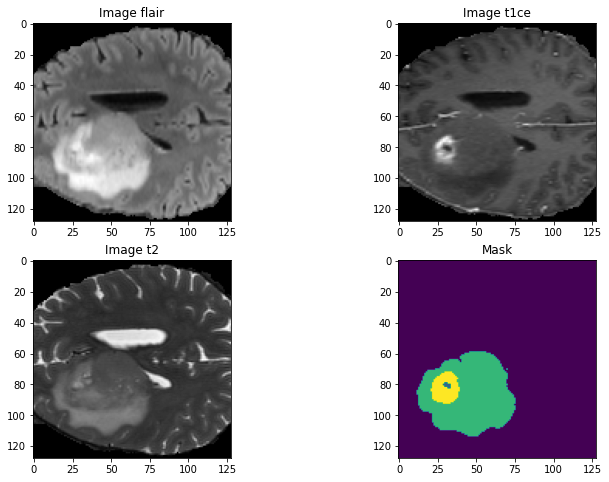

In [ ]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = test_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')

plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')

plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

#10th Epoch results 

In [ ]:
#25th Epoch results 
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

# Evaluating the model on the Test Data
model1.evaluate(x=test_image_batch, y=test_mask_batch, batch_size=10, verbose=1, sample_weight=None, steps=None)

1/1 [==============================] - 156s 156s/step - loss: 0.0849 - dice_coefficient: 0.9151 - brats_wt: 0.9184 - brats_tc: 0.8979 - brats_et: 0.8595 - sensitivity: 0.9888 - specificity: 0.9967


[0.08485138416290283,
 0.9151486158370972,
 0.9183637499809265,
 0.897910475730896,
 0.8595204949378967,
 0.9888062477111816,
 0.9967160224914551]

In [ ]:
#30th Epoch results 
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

# Evaluating the model on the Test Data
model1.evaluate(x=test_image_batch, y=test_mask_batch, batch_size=10, verbose=1, sample_weight=None, steps=None)

1/1 [==============================] - 147s 147s/step - loss: 0.1024 - dice_coefficient: 0.8976 - brats_wt: 0.9120 - brats_tc: 0.8899 - brats_et: 0.8974 - sensitivity: 0.9868 - specificity: 0.9960


[0.10244083404541016,
 0.8975591659545898,
 0.9120041131973267,
 0.8899003267288208,
 0.8973885178565979,
 0.986778736114502,
 0.9959962964057922]

In [ ]:
#35th Epoch results 
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

# Evaluating the model on the Test Data
model1.evaluate(x=test_image_batch, y=test_mask_batch, batch_size=10, verbose=1, sample_weight=None, steps=None)

1/1 [==============================] - 157s 157s/step - loss: 0.0725 - dice_coefficient: 0.9275 - brats_wt: 0.8553 - brats_tc: 0.9620 - brats_et: 0.9259 - sensitivity: 0.9823 - specificity: 0.9945


[0.07251918315887451,
 0.9274808168411255,
 0.8553317189216614,
 0.9620308876037598,
 0.925936758518219,
 0.9822726249694824,
 0.9945321083068848]

In [ ]:
#40th Epoch results 
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

# Evaluating the model on the Test Data
model1.evaluate(x=test_image_batch, y=test_mask_batch, batch_size=10, verbose=1, sample_weight=None, steps=None)

1/1 [==============================] - 3s 3s/step - loss: 0.0850 - dice_coefficient: 0.9150 - brats_wt: 0.8834 - brats_tc: 0.9222 - brats_et: 0.9087 - sensitivity: 0.9846 - specificity: 0.9953


[0.08498978614807129,
 0.9150102138519287,
 0.8834264874458313,
 0.9221577048301697,
 0.9087048172950745,
 0.9846115112304688,
 0.9952864646911621]

In [ ]:
#40th epoch
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.5932946


In [ ]:
#35th epoch
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 282s 282s/step
Mean IoU = 0.5900948


In [ ]:
#30th epoch
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 284s 284s/step
Mean IoU = 0.58902967


In [ ]:
#25th epoch
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 285s 285s/step
Mean IoU = 0.5196405


In [ ]:
# 16 Epoch results 
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

# Evaluating the model on the Test Data
model1.evaluate(x=test_image_batch, y=test_mask_batch, batch_size=10, verbose=1, sample_weight=None, steps=None)

1/1 [==============================] - 147s 147s/step - loss: 0.1481 - dice_coefficient: 0.8519 - brats_wt: 0.8809 - brats_tc: 0.8564 - brats_et: 0.8173 - sensitivity: 0.9823 - specificity: 0.9949


[0.1480776071548462,
 0.8519223928451538,
 0.880875825881958,
 0.8563605546951294,
 0.8173360824584961,
 0.9822869300842285,
 0.99488765001297]

#10th epoch results 

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 308s 308s/step
Mean IoU = 0.5401247


#16th Epoch Results 

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 281s 281s/step
Mean IoU = 0.5486451


In [ ]:
import numpy as np
a=np.load('/content/drive/MyDrive/trynpymgmt/0.npy')
print(a.shape)



(36, 256, 256, 4)


1/1 [==============================] - 83s 83s/step


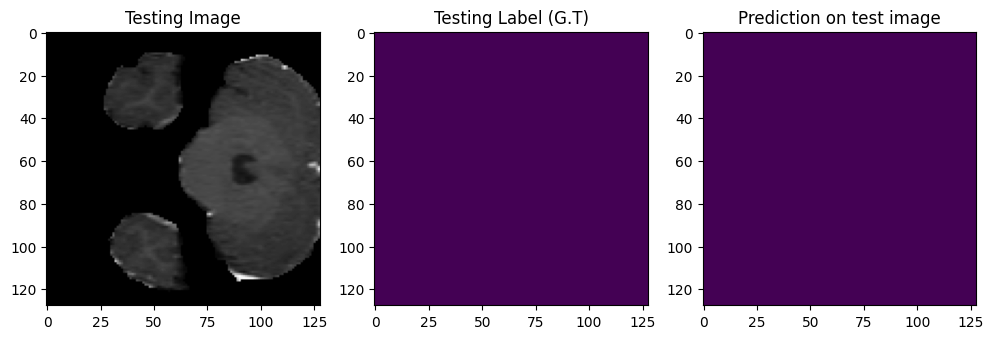

In [ ]:
#############################################
#Predict on a few test images, one at a time

img_num = 0

# test_img = np.load("/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_images"+str(img_num)+".npy")
test_img = np.load("/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_images/0.npy")

test_mask = np.load("/content/drive/MyDrive/Brats2021_Training_dataset/BraTS2021_Train_Test_Data/train/train_masks/0.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model1.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]



#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 24
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label (G.T)')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


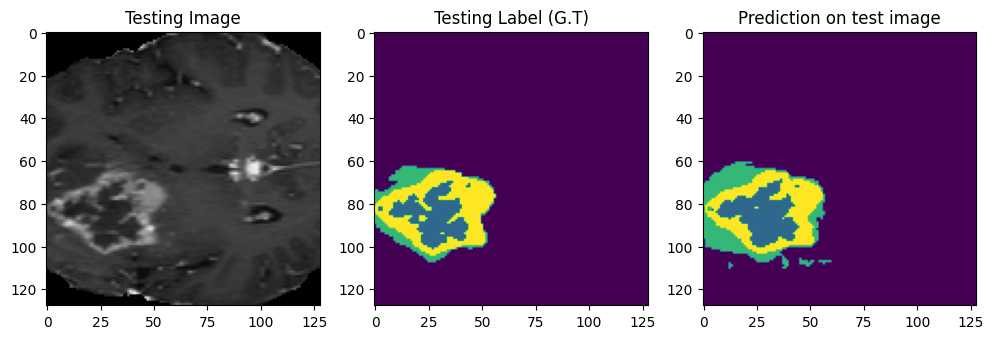

In [ ]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 60
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label (G.T)')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [ ]:
brats_wt = [0.2684, 0.7390, 0.7940, 0.8140, 0.8262, 0.8347, 0.8388, 0.8420, 0.8441, 0.8461,0.8568, 0.8609, 0.8652, 0.8672, 0.8685, 0.8729, 0.8731, 0.8751, 0.8774, 0.8797, 0.8820, 0.8840, 0.8856, 0.8872, 0.8886,0.8882, 0.8896, 0.8898, 0.8918, 0.8939, 0.8932, 0.8968, 0.8994, 0.9002, 0.9013, 0.8993, 0.8983, 0.8991, 0.9010, 0.9028]

brats_tc = [0.0762, 0.5044, 0.6833, 0.7285, 0.7525, 0.7722, 0.7838, 0.7944, 0.8032, 0.8120,0.8213, 0.8289, 0.8371, 0.8414, 0.8455, 0.8532, 0.8558, 0.8597, 0.8633, 0.8671, 0.8708, 0.8736, 0.8761, 0.8780, 0.8800,0.8826, 0.8854, 0.8828, 0.8849, 0.8898, 0.8910, 0.8937, 0.8984, 0.8981, 0.8985,0.9008, 0.8989, 0.9009, 0.9019, 0.9052]

brats_et = [0.4531, 0.6443, 0.6722, 0.6985, 0.7175, 0.7323, 0.7462, 0.7564, 0.7642, 0.7725,0.7762, 0.7826, 0.7897, 0.7946, 0.7978, 0.8025, 0.8049, 0.8079, 0.8112, 0.8145, 0.8178, 0.8207, 0.8233, 0.8257, 0.8279,0.8302, 0.8331, 0.8303, 0.8327, 0.8381, 0.8391, 0.8418, 0.8504, 0.8482, 0.8518, 0.8463, 0.8462, 0.8492, 0.8497, 0.8528]

val_wt count: 40
val_tc count: 40
val_tc count: 40


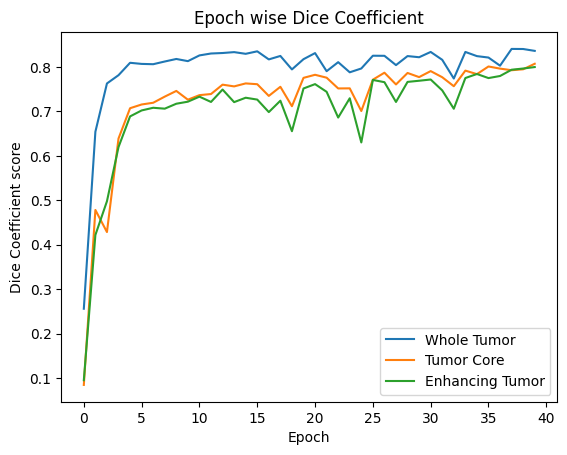

In [ ]:
import matplotlib.pyplot as plt
# Sample values for training and validation accuracy at each epoch
# train_acc = [0.4065, 0.6028, 0.7254, 0.7635, 0.7842, 0.7971, 0.8067, 0.8139, 0.8203, 0.8255,0.8317,0.8364,0.8418,0.8477,0.8475,0.8528,0.8558,0.8567,0.8590,0.8626,0.8640,0.8699,0.8704,0.8754,0.8774,0.8767,0.8776,0.8820,0.8825,0.8851,0.8845,0.8863,0.8884,0.8898,0.8893,0.8910,0.8921,0.8941]
# val_acc = [0.2703,0.5503,0.5959,0.7354,0.7743,0.7794,0.7620,0.7905,0.7747,0.7985,0.7906,0.7874,0.8004,0.7903,0.7899,0.7924,0.7893,0.7657,0.8016,0.8092,0.7933,0.7800,0.7857,0.7452,0.8111,0.8132,0.7916,0.8121,0.8046,0.8221,0.8075,0.7833,0.8199,0.8142,0.8270,0.8144,0.8237,0.8249,0.8219,0.8307] dice_coefficient: 0.8519 - brats_wt: 0.8809 - brats_tc: 0.8564 - brats_et: 0.8173
brats_wt = [0.2684, 0.7390, 0.7940, 0.8140, 0.8262, 0.8347, 0.8388, 0.8420, 0.8441, 0.8461,0.8568, 0.8609, 0.8652, 0.8672, 0.8685, 0.8729, 0.8731, 0.8751, 0.8774, 0.8797, 0.8820, 0.8840, 0.8856, 0.8872, 0.8886,0.8882, 0.8896, 0.8898, 0.8918, 0.8939, 0.8932, 0.8968, 0.8994, 0.9002, 0.9013, 0.8993, 0.8983, 0.8991, 0.9010, 0.9028]

brats_tc = [0.0762, 0.5044, 0.6833, 0.7285, 0.7525, 0.7722, 0.7838, 0.7944, 0.8032, 0.8120,0.8213, 0.8289, 0.8371, 0.8414, 0.8455, 0.8532, 0.8558, 0.8597, 0.8633, 0.8671, 0.8708, 0.8736, 0.8761, 0.8780, 0.8800,0.8826, 0.8854, 0.8828, 0.8849, 0.8898, 0.8910, 0.8937, 0.8984, 0.8981, 0.8985,0.9008, 0.8989, 0.9009, 0.9019, 0.9052]

brats_et = [0.4531, 0.6443, 0.6722, 0.6985, 0.7175, 0.7323, 0.7462, 0.7564, 0.7642, 0.7725,0.7762, 0.7826, 0.7897, 0.7946, 0.7978, 0.8025, 0.8049, 0.8079, 0.8112, 0.8145, 0.8178, 0.8207, 0.8233, 0.8257, 0.8279,0.8302, 0.8331, 0.8303, 0.8327, 0.8381, 0.8391, 0.8418, 0.8504, 0.8482, 0.8518, 0.8463, 0.8462, 0.8492, 0.8497, 0.8528]

val_wt=[0.2561, 0.6543, 0.7629, 0.7815, 0.8094, 0.8069, 0.8062, 0.8123, 0.8180, 0.8131, 0.8260, 0.8303, 0.8314, 0.8334, 0.8296, 0.8352, 0.8170, 0.8248,0.7945, 0.8175, 0.8312, 0.7905, 0.8108, 0.7880, 0.7966,0.8253,0.8251, 0.8042, 0.8245, 0.8219, 0.8338,0.8161 , 0.7740 , 0.8338 , 0.8244 , 0.8212,0.8029 , 0.8406 , 0.8404 , 0.8362 ]
val_tc=[0.0847, 0.4783, 0.4286, 0.6390, 0.7072, 0.7156, 0.7195, 0.7333, 0.7461, 0.7264,0.7366, 0.7391, 0.7602, 0.7563, 0.7630, 0.7612, 0.7349, 0.7554,0.7117, 0.7755, 0.7824, 0.7759, 0.7517, 0.7519, 0.7009,0.7714,0.7871, 0.7607, 0.7865, 0.7772, 0.7907,0.7769 , 0.7567 , 0.7918 , 0.7839 , 0.8011, 0.7963 , 0.7927 , 0.7948  , 0.8072 ]
val_et=[0.0953, 0.4220, 0.4979, 0.6198, 0.6888, 0.7022, 0.7082, 0.7062, 0.7173, 0.7219,0.7332, 0.7213, 0.7492, 0.7209, 0.7308, 0.7266, 0.6985, 0.7241,0.6555, 0.7516, 0.7614, 0.7441, 0.6862, 0.7296, 0.6302,0.7708,0.7658, 0.7213, 0.7664, 0.7690, 0.7718,0.7473 , 0.7060 , 0.7751 , 0.7842 , 0.7750, 0.7797 , 0.7938 , 0.7965  , 0.7998 ]
# plot the training and validation accuracy
brats_wt_count = len(brats_wt)
brats_tc_count = len(brats_tc)
brats_et_count = len(brats_et)
val_wt_count = len(val_wt)
val_tc_count = len(val_tc)
val_et_count=len(val_et)


# print("brats_wt count:", brats_wt_count)
# print("brats_tc count:", brats_tc_count)
# print("brats_et count:", brats_et_count)
print("val_wt count:", val_wt_count)
print("val_tc count:", val_tc_count)
print("val_tc count:", val_et_count)



# plt.plot(brats_wt, label='Whole Tumor')
# plt.plot(brats_tc, label='Tumor Core')
# plt.plot(brats_et, label='Enhancing Tumor')
plt.plot(val_wt, label='Whole Tumor')
plt.plot(val_tc, label='Tumor Core')
plt.plot(val_et, label='Enhancing Tumor')

# set the plot title, x-axis label, and y-axis label
plt.title('Epoch wise Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient score')

# set the legend
plt.legend()

# display the plot
plt.show()


brats_wt count: 40
brats_tc count: 40
brats_et count: 40
val_wt count: 40
val_tc count: 40
val_tc count: 40


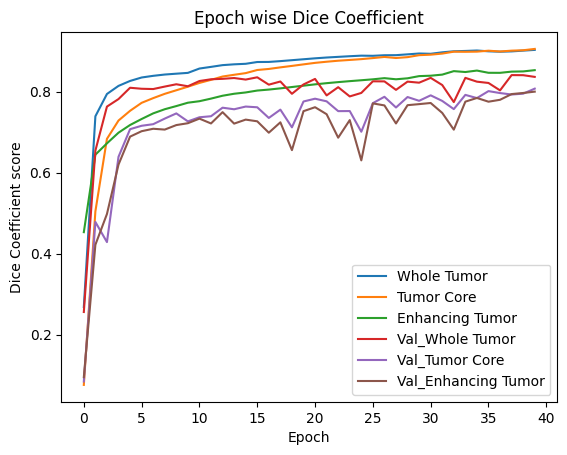

In [ ]:
import matplotlib.pyplot as plt
# Sample values for training and validation accuracy at each epoch
# train_acc = [0.4065, 0.6028, 0.7254, 0.7635, 0.7842, 0.7971, 0.8067, 0.8139, 0.8203, 0.8255,0.8317,0.8364,0.8418,0.8477,0.8475,0.8528,0.8558,0.8567,0.8590,0.8626,0.8640,0.8699,0.8704,0.8754,0.8774,0.8767,0.8776,0.8820,0.8825,0.8851,0.8845,0.8863,0.8884,0.8898,0.8893,0.8910,0.8921,0.8941]
# val_acc = [0.2703,0.5503,0.5959,0.7354,0.7743,0.7794,0.7620,0.7905,0.7747,0.7985,0.7906,0.7874,0.8004,0.7903,0.7899,0.7924,0.7893,0.7657,0.8016,0.8092,0.7933,0.7800,0.7857,0.7452,0.8111,0.8132,0.7916,0.8121,0.8046,0.8221,0.8075,0.7833,0.8199,0.8142,0.8270,0.8144,0.8237,0.8249,0.8219,0.8307]
brats_wt = [0.2684, 0.7390, 0.7940, 0.8140, 0.8262, 0.8347, 0.8388, 0.8420, 0.8441, 0.8461,0.8568, 0.8609, 0.8652, 0.8672, 0.8685, 0.8729, 0.8731, 0.8751, 0.8774, 0.8797, 0.8820, 0.8840, 0.8856, 0.8872, 0.8886,0.8882, 0.8896, 0.8898, 0.8918, 0.8939, 0.8932, 0.8968, 0.8994, 0.9002, 0.9013, 0.8993, 0.8983, 0.8991, 0.9010, 0.9028]

brats_tc = [0.0762, 0.5044, 0.6833, 0.7285, 0.7525, 0.7722, 0.7838, 0.7944, 0.8032, 0.8120,0.8213, 0.8289, 0.8371, 0.8414, 0.8455, 0.8532, 0.8558, 0.8597, 0.8633, 0.8671, 0.8708, 0.8736, 0.8761, 0.8780, 0.8800,0.8826, 0.8854, 0.8828, 0.8849, 0.8898, 0.8910, 0.8937, 0.8984, 0.8981, 0.8985,0.9008, 0.8989, 0.9009, 0.9019, 0.9052]

brats_et = [0.4531, 0.6443, 0.6722, 0.6985, 0.7175, 0.7323, 0.7462, 0.7564, 0.7642, 0.7725,0.7762, 0.7826, 0.7897, 0.7946, 0.7978, 0.8025, 0.8049, 0.8079, 0.8112, 0.8145, 0.8178, 0.8207, 0.8233, 0.8257, 0.8279,0.8302, 0.8331, 0.8303, 0.8327, 0.8381, 0.8391, 0.8418, 0.8504, 0.8482, 0.8518, 0.8463, 0.8462, 0.8492, 0.8497, 0.8528]

val_wt=[0.2561, 0.6543, 0.7629, 0.7815, 0.8094, 0.8069, 0.8062, 0.8123, 0.8180, 0.8131, 0.8260, 0.8303, 0.8314, 0.8334, 0.8296, 0.8352, 0.8170, 0.8248,0.7945, 0.8175, 0.8312, 0.7905, 0.8108, 0.7880, 0.7966,0.8253,0.8251, 0.8042, 0.8245, 0.8219, 0.8338,0.8161 , 0.7740 , 0.8338 , 0.8244 , 0.8212,0.8029 , 0.8406 , 0.8404 , 0.8362 ]
val_tc=[0.0847, 0.4783, 0.4286, 0.6390, 0.7072, 0.7156, 0.7195, 0.7333, 0.7461, 0.7264,0.7366, 0.7391, 0.7602, 0.7563, 0.7630, 0.7612, 0.7349, 0.7554,0.7117, 0.7755, 0.7824, 0.7759, 0.7517, 0.7519, 0.7009,0.7714,0.7871, 0.7607, 0.7865, 0.7772, 0.7907,0.7769 , 0.7567 , 0.7918 , 0.7839 , 0.8011, 0.7963 , 0.7927 , 0.7948  , 0.8072 ]
val_et=[0.0953, 0.4220, 0.4979, 0.6198, 0.6888, 0.7022, 0.7082, 0.7062, 0.7173, 0.7219,0.7332, 0.7213, 0.7492, 0.7209, 0.7308, 0.7266, 0.6985, 0.7241,0.6555, 0.7516, 0.7614, 0.7441, 0.6862, 0.7296, 0.6302,0.7708,0.7658, 0.7213, 0.7664, 0.7690, 0.7718,0.7473 , 0.7060 , 0.7751 , 0.7842 , 0.7750, 0.7797 , 0.7938 , 0.7965  , 0.7998 ]
# plot the training and validation accuracy
brats_wt_count = len(brats_wt)
brats_tc_count = len(brats_tc)
brats_et_count = len(brats_et)
val_wt_count = len(val_wt)
val_tc_count = len(val_tc)
val_et_count=len(val_et)


print("brats_wt count:", brats_wt_count)
print("brats_tc count:", brats_tc_count)
print("brats_et count:", brats_et_count)
print("val_wt count:", val_wt_count)
print("val_tc count:", val_tc_count)
print("val_tc count:", val_et_count)



plt.plot(brats_wt, label='Whole Tumor')
plt.plot(brats_tc, label='Tumor Core')
plt.plot(brats_et, label='Enhancing Tumor')
plt.plot(val_wt, label='Val_Whole Tumor')
plt.plot(val_tc, label='Val_Tumor Core')
plt.plot(val_et, label='Val_Enhancing Tumor')

# set the plot title, x-axis label, and y-axis label
plt.title('Epoch wise Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient score')

# set the legend
plt.legend()

# display the plot
plt.show()


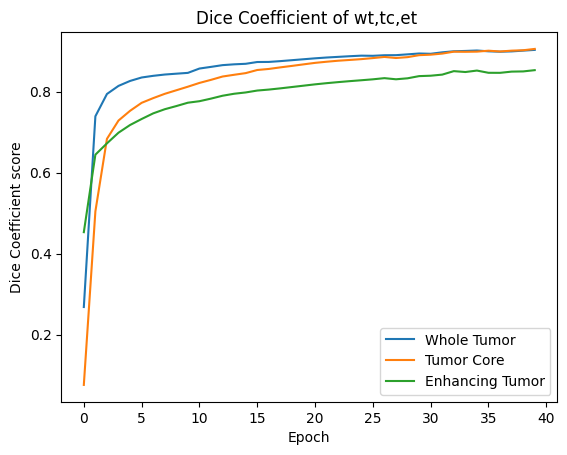

In [ ]:
import matplotlib.pyplot as plt
# Sample values for training and validation accuracy at each epoch
# train_acc = [0.4065, 0.6028, 0.7254, 0.7635, 0.7842, 0.7971, 0.8067, 0.8139, 0.8203, 0.8255,0.8317,0.8364,0.8418,0.8477,0.8475,0.8528,0.8558,0.8567,0.8590,0.8626,0.8640,0.8699,0.8704,0.8754,0.8774,0.8767,0.8776,0.8820,0.8825,0.8851,0.8845,0.8863,0.8884,0.8898,0.8893,0.8910,0.8921,0.8941]
# val_acc = [0.2703,0.5503,0.5959,0.7354,0.7743,0.7794,0.7620,0.7905,0.7747,0.7985,0.7906,0.7874,0.8004,0.7903,0.7899,0.7924,0.7893,0.7657,0.8016,0.8092,0.7933,0.7800,0.7857,0.7452,0.8111,0.8132,0.7916,0.8121,0.8046,0.8221,0.8075,0.7833,0.8199,0.8142,0.8270,0.8144,0.8237,0.8249,0.8219,0.8307]
brats_wt = [0.2684, 0.7390, 0.7940, 0.8140, 0.8262, 0.8347, 0.8388, 0.8420, 0.8441, 0.8461,0.8568, 0.8609, 0.8652, 0.8672, 0.8685, 0.8729, 0.8731, 0.8751, 0.8774, 0.8797, 0.8820, 0.8840, 0.8856, 0.8872, 0.8886,0.8882, 0.8896, 0.8898, 0.8918, 0.8939, 0.8932, 0.8968, 0.8994, 0.9002, 0.9013, 0.8993, 0.8983, 0.8991, 0.9010, 0.9028]

brats_tc = [0.0762, 0.5044, 0.6833, 0.7285, 0.7525, 0.7722, 0.7838, 0.7944, 0.8032, 0.8120,0.8213, 0.8289, 0.8371, 0.8414, 0.8455, 0.8532, 0.8558, 0.8597, 0.8633, 0.8671, 0.8708, 0.8736, 0.8761, 0.8780, 0.8800,0.8826, 0.8854, 0.8828, 0.8849, 0.8898, 0.8910, 0.8937, 0.8984, 0.8981, 0.8985,0.9008, 0.8989, 0.9009, 0.9019, 0.9052]

brats_et = [0.4531, 0.6443, 0.6722, 0.6985, 0.7175, 0.7323, 0.7462, 0.7564, 0.7642, 0.7725,0.7762, 0.7826, 0.7897, 0.7946, 0.7978, 0.8025, 0.8049, 0.8079, 0.8112, 0.8145, 0.8178, 0.8207, 0.8233, 0.8257, 0.8279,0.8302, 0.8331, 0.8303, 0.8327, 0.8381, 0.8391, 0.8418, 0.8504, 0.8482, 0.8518, 0.8463, 0.8462, 0.8492, 0.8497, 0.8528]

# val_wt=[0.2561, 0.6543, 0.7629, 0.7815, 0.8094, 0.8069, 0.8062, 0.8123, 0.8180, 0.8131, 0.8260, 0.8303, 0.8314, 0.8334, 0.8296, 0.8352, 0.8170, 0.8248,0.7945, 0.8175, 0.8312, 0.7905, 0.8108, 0.7880, 0.7966,0.8253,0.8251, 0.8042, 0.8245, 0.8219, 0.8338,0.8161 , 0.7740 , 0.8338 , 0.8244 , 0.8212,0.8029 , 0.8406 , 0.8404 , 0.8192 , 0.8362 ]
# val_tc=[0.0847, 0.4783, 0.4286, 0.6390, 0.7072, 0.7156, 0.7195, 0.7333, 0.7461, 0.7264,0.7366, 0.7391, 0.7602, 0.7563, 0.7630, 0.7612, 0.7349, 0.7554,0.7117, 0.7755, 0.7824, 0.7759, 0.7517, 0.7519, 0.7009,0.7714,0.7871, 0.7607, 0.7865, 0.7772, 0.7907,0.7769 , 0.7567 , 0.7918 , 0.7839 , 0.8011, 0.7963 , 0.7927 , 0.7948 , 0.8062 , 0.8072 ]
# val_et=[0.0953, 0.4220, 0.4979, 0.6198, 0.6888, 0.7022, 0.7082, 0.7062, 0.7173, 0.7219,0.7332, 0.7213, 0.7492, 0.7209, 0.7308, 0.7266, 0.6985, 0.7241,0.6555, 0.7516, 0.7614, 0.7441, 0.6862, 0.7296, 0.6302,0.7708,0.7658, 0.7213, 0.7664, 0.7690, 0.7718,0.7473 , 0.7060 , 0.7751 , 0.7842 , 0.7750, 0.7797 , 0.7938 , 0.7965 , 0.8036 , 0.7998 ]
# plot the training and validation accuracy
plt.plot(brats_wt, label='Whole Tumor')
plt.plot(brats_tc, label='Tumor Core')
plt.plot(brats_et, label='Enhancing Tumor')
# plt.plot(val_wt, label='Val_Whole Tumor')
# plt.plot(val_tc, label='Val_Tumor Core')
# plt.plot(val_et, label='Val_Enhancing Tumor')

# set the plot title, x-axis label, and y-axis label
plt.title('Epoch wise Dice Coefficient  ')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient score')

# set the legend
plt.legend()

# display the plot
plt.show()


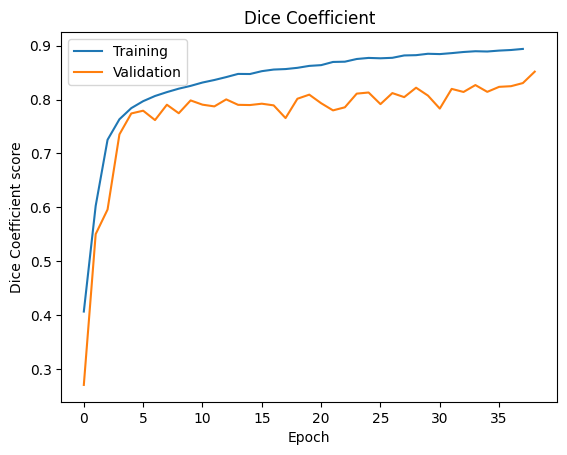

In [ ]:
import matplotlib.pyplot as plt
# Sample values for training and validation accuracy at each epoch dice_coefficient: 0.8519 - brats_wt: 0.8809 - brats_tc: 0.8564 - brats_et: 0.8173
train_dice_score = [0.4065, 0.6028, 0.7254, 0.7635, 0.7842, 0.7971, 0.8067, 0.8139, 0.8203, 0.8255,0.8317,0.8364,0.8418,0.8477,0.8475,0.8528,0.8558,0.8567,0.8590,0.8626,0.8640,0.8699,0.8704,0.8754,0.8774,0.8767,0.8776,0.8820,0.8825,0.8851,0.8845,0.8863,0.8884,0.8898,0.8893,0.8910,0.8921,0.8941]
val_dice_score = [0.2703,0.5503,0.5959,0.7354,0.7743,0.7794,0.7620,0.7905,0.7747,0.7985,0.7906,0.7874,0.8004,0.7903,0.7899,0.7924,0.7893,0.7657,0.8016,0.8092,0.7933,0.7800,0.7857,0.8111,0.8132,0.7916,0.8121,0.8046,0.8221,0.8075,0.7833,0.8199,0.8142,0.8270,0.8144,0.8237,0.8249,0.8307,0.8519]
# brats_wt = [0.2684, 0.7390, 0.7940, 0.8140, 0.8262, 0.8347, 0.8388, 0.8420, 0.8441, 0.8461,0.8568, 0.8609, 0.8652, 0.8672, 0.8685, 0.8729, 0.8731, 0.8751, 0.8774, 0.8797, 0.8820, 0.8840, 0.8856, 0.8872, 0.8886,0.8882, 0.8896, 0.8898, 0.8918, 0.8939, 0.8932, 0.8968, 0.8994, 0.9002, 0.9013, 0.8993, 0.8983, 0.8991, 0.9010, 0.9028]

# brats_tc = [0.0762, 0.5044, 0.6833, 0.7285, 0.7525, 0.7722, 0.7838, 0.7944, 0.8032, 0.8120,0.8213, 0.8289, 0.8371, 0.8414, 0.8455, 0.8532, 0.8558, 0.8597, 0.8633, 0.8671, 0.8708, 0.8736, 0.8761, 0.8780, 0.8800,0.8826, 0.8854, 0.8828, 0.8849, 0.8898, 0.8910, 0.8937, 0.8984, 0.8981, 0.8985,0.9008, 0.8989, 0.9009, 0.9019, 0.9052]

# brats_et = [0.4531, 0.6443, 0.6722, 0.6985, 0.7175, 0.7323, 0.7462, 0.7564, 0.7642, 0.7725,0.7762, 0.7826, 0.7897, 0.7946, 0.7978, 0.8025, 0.8049, 0.8079, 0.8112, 0.8145, 0.8178, 0.8207, 0.8233, 0.8257, 0.8279,0.8302, 0.8331, 0.8303, 0.8327, 0.8381, 0.8391, 0.8418, 0.8504, 0.8482, 0.8518, 0.8463, 0.8462, 0.8492, 0.8497, 0.8528]
# plot the training and validation accuracy
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
# plt.plot(brats_et, label='Enhancing Tumor')

# set the plot title, x-axis label, and y-axis label
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient score')

# set the legend
plt.legend()

# display the plot
plt.show()


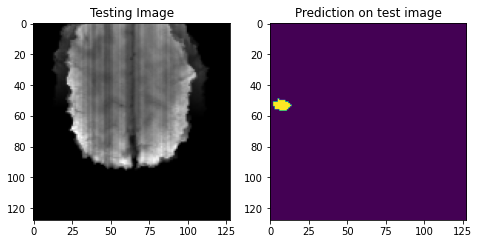

In [ ]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 64
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[n_slice,:,:,1], cmap='gray')
plt.subplot(232)
# plt.title('Testing Label (G.T)')
# plt.imshow(test_mask_argmax[:,:,n_slice])
# plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()